[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/chaoss/wg-evolution/master?filepath=implementations/Code_Changes-Git.ipynb)
# Code_Changes-Git

This is the reference implementation for Code_Changes,
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

See [README.md](README.md) to find out how to run this notebook (and others in this directory).

The implementation is described in two parts (see below):

* Retrieving data from the data source
* Class for computing Code_Changes

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Examples of how to check for specific peculiarities of git commits

## Retrieving data from the data source

From the command line run Perceval on the git repositories to analyze,
to produce a file with JSON documents for all its commits,
one per line (`git-commits.json`).

As an example we will use the Perceval, SortingHat, and a fork of SortingHat
git repositories:
change it to get data from your preferred repositories
(for example, you can use `https://github.com/elastic/elasticsearch-docker`
or `https://github.com/git/git`):

```
$ perceval git --json-line http://github.com/chaoss/grimoirelab-perceval > git-commits.json
[2019-01-28 21:05:45,461] - Sir Perceval is on his quest.
[2019-01-28 21:05:48,229] - Fetching commits: 'http://github.com/chaoss/grimoirelab-perceval' git repository from 1970-01-01 00:00:00+00:00 to 2100-01-01 00:00:00+00:00; all branches
[2019-01-28 21:05:49,727] - Fetch process completed: 1320 commits fetched
[2019-01-28 21:05:49,728] - Sir Perceval completed his quest.
$ perceval git --json-line http://github.com/chaoss/grimoirelab-sortinghat >> git-commits.json
...
[2019-01-28 21:07:27,169] - Fetch process completed: 635 commits fetched
[2019-01-28 21:07:27,169] - Sir Perceval completed his quest.
$ perceval git --json-line http://github.com/jgbarah-chaoss/grimoirelab-sortinghat >> git-commits.json
...
[2019-01-28 23:58:47,068] - Fetch process completed: 567 commits fetched
[2019-01-28 23:58:47,068] - Sir Perceval completed his quest.
```

In [1]:
import json
import datetime
import matplotlib.pyplot as plt
import pandas as pd

## Class for computing Code_Changes-Git

This implementation uses data retrieved as described above.
The implementation is encapsulated in the `Code_Changes` class,
which gets all commits for a set of repositories.

In [6]:
class Code_Changes:
    """Class for Code_Changes for Git repositories.
    
    Objects are instantiated by specifying a file with the
    commits obtained by Perceval from a set of repositories.
        
    :param path: Path to file with one Perceval JSON document per line
    """

    @staticmethod
    def _summary(repo, cdata):
        """Compute a summary of a commit, suitable as a row in a dataframe"""
        
        summary = {
            'repo': repo,
            'hash': cdata['commit'],
            'author': cdata['Author'],
            'author_date': datetime.datetime.strptime(cdata['AuthorDate'],
                                                      "%a %b %d %H:%M:%S %Y %z"),
            'commit': cdata['Commit'],
            'commit_date': datetime.datetime.strptime(cdata['CommitDate'],
                                                      "%a %b %d %H:%M:%S %Y %z"),
            'files_no': len(cdata['files']),
            'refs': cdata['refs'],
            'parents': cdata['parents'],
            'files': cdata['files']
        }
        
        actions = 0
        for file in cdata['files']:
            if 'action' in file:
                actions += 1
        summary['files_action'] = actions
        if 'Merge' in cdata:
            summary['merge'] = True
        else:
            summary['merge'] = False
        return summary;
    
    def __init__(self, path, since=None, until=None, source_code_exclude_list=None):
        """
        Initilizes self.df, the dataframe with one commit per row.
        The source_code_exclude_list parameter is a list which contains file extensions
        which are to be ignored. All possible file extensions are allowed. 
        For files without a standard ".xyz" extension, like LICENCE or AUTHORS, the "others" 
        extension is used. 
        
        :param since: Period start
        :param until: Period end
        :param source_code_exclude_list: Files extensions to exclude. For example, 
            source_code_exclude_list = ["py", "other", "gitignore"]
        """
        
        self.since = since
        self.until = until
        self.source_code_exclude_list = source_code_exclude_list
        self.repo_urls = set()
        
        commits = []
        with open(path) as commits_file:
            for line in commits_file:
                commit = json.loads(line)
                commit = self._summary(repo=commit['origin'], cdata=commit['data'])
                self.repo_urls.add(commit['repo'])
                
                if self._is_source_code(commit):
                    commits.append(commit)
                    
        self.df = pd.DataFrame(commits)
        self.df['author_date'] = pd.to_datetime(self.df['author_date'], utc=True)
        self.df['commit_date'] = pd.to_datetime(self.df['commit_date'], utc=True)
        print(self.repo_urls)
        
        if self.since:
            self.df = self.df[self.df['author_date'] >= self.since]
        if self.until:
            self.df = self.df[self.df['author_date'] < self.until]
        
    def total_count(self):
        """
        Get a naive count of the number of commits in the Perceval data.
        Note that some commits may be repeated and so total_count may 
        overshoot.
        """
        return len(self.df.index)
    
    def compute(self, empty=True, merge=True, master_only=False):
        """Count number of commits of different types
        
        :param empty: Include empty commits
        :param merge: Include merge commits
        :param master_only: Include only commits made on master branch
        """
        count_per_repo = dict()
        
        for repo_url in self.repo_urls:
            df = self.df[self.df['repo'] == repo_url]
            
            if master_only:
                count_per_repo[repo_url] = self._count_master_only(repo_url, empty)

            else:
                if not empty:
                    df = df[df['files_action'] != 0]
                if not merge:
                    df = df[df['merge'] == False]
                count_per_repo[repo_url] = df['hash'].nunique()
            
        return count_per_repo
    
    def compute_timeseries(self, period="month", plot_chart=False):
        """
        The metric value is computed for each fixed interval of time
        from the "since" date to the "until" date arguments, specified 
        during object initiation.
        
        The fixed time interval can be either a month or a week.
        
        :param period: A string which can be either "month" or "week"
        :param plot_chart: Plots a barchart of the timeseries if True
        """
        dataframe_per_repo = dict()
        for repo_url in self.repo_urls:
            
            df = self.df[self.df['repo'] == repo_url]
            if period == "month":
                timeseries_series =  df['author_date'] \
                    .groupby([df.author_date.dt.year.rename('year'),
                              df.author_date.dt.month.rename('month')]) \
                    .agg('count')

                all_periods = pd.DataFrame(pd.date_range(self.since, self.until, freq='M'), columns=["Dates"])
                all_periods = pd.DataFrame(    \
                    [all_periods['Dates'].dt.year.rename("year"),   \
                     all_periods['Dates'].dt.month.rename("month")]).T

            elif period == "week":
                timeseries_series =  df['author_date'] \
                    .groupby([df.author_date.dt.year.rename('year'),
                              df.author_date.dt.week.rename('week')]) \
                    .agg('count') 

                all_periods = pd.DataFrame(pd.date_range(self.since, self.until, freq='W'), columns=["Dates"])
                all_periods = pd.DataFrame(    \
                    [all_periods['Dates'].dt.year.rename("year"),   \
                     all_periods['Dates'].dt.week.rename("week")]).T


            timeseries_df = pd.DataFrame(timeseries_series)
            timeseries_df.reset_index(inplace=True)
            timeseries_df.columns = ["year", period, "count"]
            merged_df = all_periods.merge(timeseries_df, how='outer').fillna(0)

            if plot_chart == True:
                plt.style.use('seaborn')
                merged_df.plot(y='count', use_index=True)
                plt.fill_between(y1=merged_df['count'], y2=0, x=merged_df.index)
                plt.title(repo_url)
            
            dataframe_per_repo[repo_url] = merged_df
        return dataframe_per_repo
    
    def _count_master_only(self, repo_url, empty=False):
        """
        Counts commits present only on the master branch.
        
        :param repo_url: count commits for a particular repository only
        :param empty: exclude empty commits on the master branch
        """
        
        df = self.df[self.df['repo'] == repo_url]
        todo = set()
        for _, commit in df.iterrows():
            if 'HEAD -> refs/heads/master' in commit['refs']:
                todo.add(commit['hash'])

        master = set()
        while len(todo) > 0:
            current = todo.pop()
            master.add(current)
            
            if len(df[df['hash'] == current]['parents']) > 0:
                for parent in df[df['hash'] == current]['parents'].iloc[0]:
                    if parent not in master:
                        todo.add(parent)
        if empty:
            code_commits = 0
            for commit_id in master:
                commit = df[df['hash'] == commit_id]
                if len(commit['files']) > 0:
                    for file in commit['files'].iloc[0]:
                        if 'action' in file:
                            code_commits += 1
                            break
                        
        else:
            code_commits = len(master)
        
        return code_commits
    
    def _is_source_code(self, commit):
        """
        Given a commit structure, which is a dictionary returned by the _summary function, 
        and given a list of files to exclude using source_code_exclude_list while instantiating 
        an object, decide whether all the files in a commit are to be excluded or not
        
        :param commit: a commit structure, returned by the _summary method.
        """
        extension_set = set()
        for file in commit['files']:
            extension_set.add(self._get_extension(file))

        if self.source_code_exclude_list is None or len(extension_set.difference(self.source_code_exclude_list)) > 0:
            return True
        return False
    
    def _get_extension(self, file):
        """
        Given a file structure, which is a dictionary and an element of commit['files'], 
        return the extension of that file. 
        For files without a standard ".xyz" extension, like LICENCE or AUTHORS, the "others" 
        extension is used. 
        
        :param file: a file structure which is a dictionary, an element of commit["files"]
        """
            
        file_name = file['file']
        if '.' in file_name:
            file_extension = file_name.split('.')[1]
        else:
            file_extension = "other"
        return file_extension

Method `count()` implements `Count` aggregation for `Code_Changes`.
It accepts parameters specified for the general metric:
    
* Period of time: `since` and `until`

It accepts parameters specified for the specific case of Git:
    
* Include merge commits: `merge`
* Include empty commits: `empty`
* Kind of date: `date`

## Examples of use of the implementation

{'http://github.com/chaoss/grimoirelab-perceval', 'http://github.com/chaoss/grimoirelab-sortinghat', 'http://github.com/jgbarah-chaoss/grimoirelab-sortinghat'}
Code changes total count: {'http://github.com/chaoss/grimoirelab-perceval': 972, 'http://github.com/chaoss/grimoirelab-sortinghat': 461, 'http://github.com/jgbarah-chaoss/grimoirelab-sortinghat': 462}
Code changes count all period: {'http://github.com/chaoss/grimoirelab-perceval': 0, 'http://github.com/chaoss/grimoirelab-sortinghat': 0, 'http://github.com/jgbarah-chaoss/grimoirelab-sortinghat': 14}


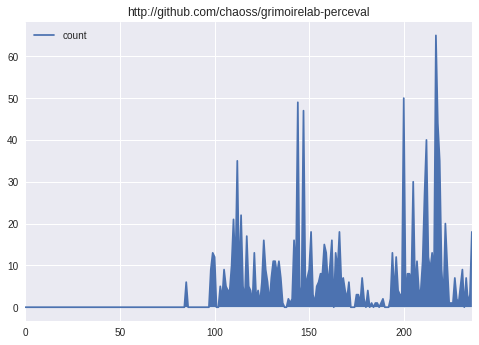

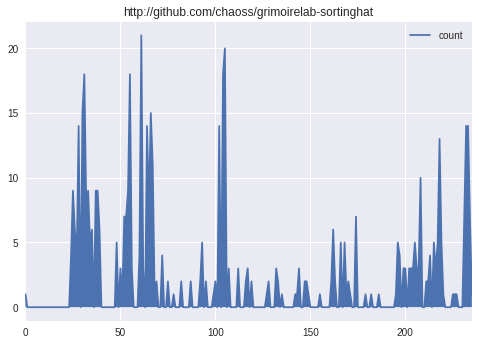

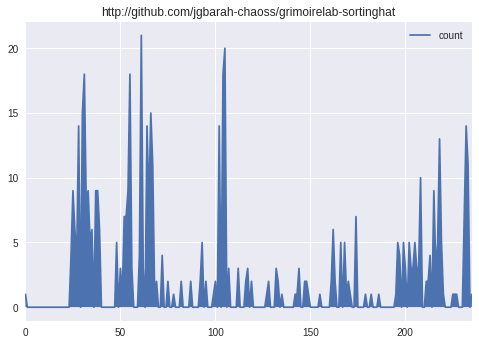

In [7]:
changes = Code_Changes('git-commits.json', source_code_exclude_list=["other"], since="2014-01-01", until="2018-07-01")
df = changes.compute_timeseries("week", True)
print("Code changes total count:", changes.compute(empty=False, merge=False))
print("Code changes count all period:", changes.compute(empty=True, master_only=True))